# W state in multi qubit systems

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.
For more information about how to use the IBM Q experience (QX), consult the tutorials, or check out the community.

## Contributors

Pierre Decoodt

In [2]:
# Checking the version of PYTHON; we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception('Please use Python version 3 or greater.')
    
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys
import time

# importing the QISKit
from qiskit import QuantumCircuit, QuantumProgram 
from qiskit import Qconfig 
# import basic plot tools
from qiskit.tools.visualization import plot_histogram

In [3]:
QPS_SPECS = {
    'circuits': [{
        'name': 'W_states',
        'quantum_registers': [{
            'name':'q',
            'size':5
        }],
        'classical_registers': [{
            'name':'c',
            'size':5
        }]}],
}

## Theoretical background

In addition to the GHZ states, the generalized W states, as proposed by Dür, Vidal and Cirac, in 2000 is a class of interesting examples of multiple qubit entanglement (ref: https://doi.org/10.1103/PhysRevA.62.062314).

A generalized n qubit W state can be written as :
$$ |W\rangle \; = \; \sqrt{\frac{1}{n}} \: (\:|10...0\rangle \: +  |01...0\rangle \: + |00...1\rangle \:) $$

Here are presented circuits allowing to deterministically produce respectively a three, a four and a five qubit W state.

A 2016 paper by Firat Diker proposes an algorithm in the form of nested boxes allowing the deterministic construction of W states of any size n. The experimental setup proposed by the author is essentially an optical assembly including half-wave plates (ref: http://arxiv.org/abs/1606.09290). The setup includes n-1 so-called two qubit $F$ gates.

It is possible to construct the equivalent of such a $F$ gate on a superconducting quantum computing system using transmon qubits in ground and excited states. In QISKit, the corresponding code for such a gate with qubit k as control and qubit k-1 as target would be for a circuit named 'W_states':

    W_states.ry(-theta,q[k-1])
    W_states.h(q[k-1])
    W_states.cx(q[k],q[k-1])
    W_states.h(q[k-1])
    W_states.ry(theta,q[k-1])

The value of theta depends now on k following the relationship:

$$\theta = \arccos \left(\sqrt{\frac{1}{k}}\right) $$


At the beginning, the qubits are in the state:  $|\varphi \rangle \, = \, |10...0\rangle$.

This is followed by n-1 sucessive $F$ gates and finally by n-1 series of k-1 cNOT gates of the form:

$$ cNOT_{1,\, k}\, \otimes \, cNOT_{2,\, k}\, \otimes ... \otimes \, cNOT_{k-2,\, k}\, \otimes \, cNOT_{k-1,\, k}$$

NB: On the actual apparatus, since the cNOT connections are unidirectional, a reverse cNOT will be used whenever necessary.

Let's launch now in the adventure of producing deterministically W states, on simulator or in the real world!

Please choose your backend.

(If you run the following cells in sequence, you will end with the local simulator, which is a good choice for a first trial).

In [4]:
# REAL QUANTUM COMPUTER!
backend = 'ibmqx4'
flag_qx2 = False

In [5]:
# REAL QUANTUM COMPUTER!
backend = 'ibmqx2'
flag_qx2 = True

In [16]:
# LOCAL SIMULATOR
# circuit compatible with ibmqx4 coupling map
backend = 'local_qasm_simulator'
flag_qx2 = False

In [15]:
# LOCAL SIMULATOR
# circuit compatible with ibmqx2 coupling map
backend = 'local_qasm_simulator'
flag_qx2 = True

## Three qubit W state, step 1

In this section, the production of a three qubit W state will be examined step by step.

The entire circuit corresponds to:                                 
                
$$ |W_{3}\rangle \,=\, cNOT_{1,3}\, \otimes \, cNOT_{2,3}\, \otimes \, cNOT_{1,2}\, \otimes \, F_{2,1} \, \otimes
\, F_{3,2} \, \otimes \, |100\rangle $$    

Run the following cell to see what happens when we execute $F_{3,2}\, \otimes \,|100\rangle$.

start W state 3 qubits (step 1) on local_qasm_simulator N= 1024 18/02/2018 17:44:11
end   W state 3 qubits (step 1) on local_qasm_simulator N= 1024 18/02/2018 17:44:15


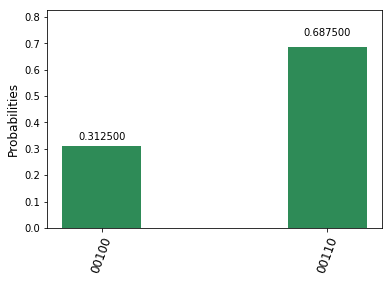

In [17]:
# 3 qubits W state Step 1

Q_program = QuantumProgram(specs=QPS_SPECS)
Q_program.set_api(Qconfig.APItoken, Qconfig.config['url'])
W_states = Q_program.get_circuit('W_states') 
q = Q_program.get_quantum_register('q') 
c = Q_program.get_classical_register('c')
        
W_states.x(q[2]) #start is |100>

# Applying F32
theta = np.arccos(np.sqrt(1/3))
W_states.ry(-theta,q[1])
W_states.h(q[1])

if flag_qx2 :
    W_states.barrier(q[1])
    W_states.h(q[1])
    W_states.h(q[2])
    W_states.cx(q[1],q[2])
    W_states.h(q[2])
    W_states.h(q[1])
    W_states.barrier(q[1],q[2])
else:
    W_states.cx(q[2],q[1])

W_states.h(q[1])
W_states.ry(theta,q[1])

for i in range(3) :
    W_states.measure(q[i] , c[i]) 

circuits = ['W_states']

shots = 1024
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('start W state 3 qubits (step 1) on', backend, "N=", shots,time_exp)
result = Q_program.execute(circuits, backend=backend, shots=shots, max_credits=5, wait=5, timeout=1200)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('end   W state 3 qubits (step 1) on', backend, "N=", shots,time_exp)
plot_histogram(result.get_counts('W_states'))

## Three qubit W state: adding step 2

In the previous step you obtained an histogram compatible with the following state:

$$ \frac{1}{\sqrt{3}} \: |100\rangle \: + \sqrt{\frac{2}{3}} \: |110\rangle $$

We seem far from the ultimate goal.

Run the following cell to see what happens when we execute $F_{2,1}\, \otimes \, F_{3,2}\, \otimes \,|100\rangle$.

start W state 3 qubits (steps 1 + 2) on local_qasm_simulator N= 1024 18/02/2018 17:44:19
end   W state 3 qubits (steps 1 + 2) on local_qasm_simulator N= 1024 18/02/2018 17:44:23


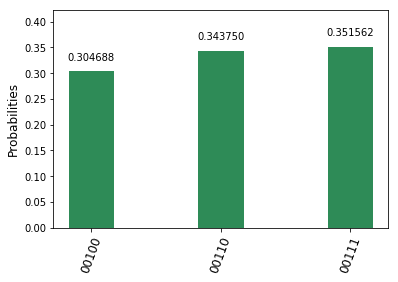

In [18]:
# 3 qubits W state, first and second steps

Q_program = QuantumProgram(specs=QPS_SPECS)
Q_program.set_api(Qconfig.APItoken, Qconfig.config['url'])
W_states = Q_program.get_circuit('W_states') 
q = Q_program.get_quantum_register('q') 
c = Q_program.get_classical_register('c')
        
W_states.x(q[2]) #start is |100>

# Applying F32
theta = np.arccos(np.sqrt(1/3))
W_states.ry(-theta,q[1])
W_states.h(q[1])

if flag_qx2 :
    W_states.barrier(q[1])
    W_states.h(q[1])
    W_states.h(q[2])
    W_states.cx(q[1],q[2])
    W_states.h(q[2])
    W_states.h(q[1])
    W_states.barrier(q[1],q[2])
else:
    W_states.cx(q[2],q[1])

W_states.h(q[1])
W_states.ry(theta,q[1])

# Applying F21
theta = np.arccos(np.sqrt(1/2))
W_states.ry(-theta,q[0])
W_states.h(q[0])

if flag_qx2 :
    W_states.barrier(q[0])
    W_states.h(q[1])
    W_states.h(q[0])
    W_states.cx(q[0],q[1])
    W_states.h(q[0])
    W_states.h(q[1])
    W_states.barrier(q[0])
else :
    W_states.cx(q[1],q[0])

W_states.h(q[0])
W_states.ry(theta,q[0])
    
for i in range(3) :
    W_states.measure(q[i] , c[i]) 

circuits = ['W_states']

shots = 1024
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('start W state 3 qubits (steps 1 + 2) on', backend, "N=", shots,time_exp)
result = Q_program.execute(circuits, backend=backend, shots=shots, max_credits=5, wait=5, timeout=1200)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('end   W state 3 qubits (steps 1 + 2) on', backend, "N=", shots,time_exp)
plot_histogram(result.get_counts('W_states'))

## Three qubit W state, full circuit

In the previous step, we got an histogram compatible with the state:

$$ \frac{1}{\sqrt{3}} \: (\:|100\rangle \: +  |110\rangle \: + |111\rangle \:) $$

It looks like we are nearing the goal.

Indeed, a succession of CNOT gate will make it possible to create a W state, that is to say an equal superposition of three pure states with a single qbit in the excited state.

Run the following cell to see what happens. Did we succeed?

start W state 3 qubits on local_qasm_simulator N= 1024 18/02/2018 17:44:28
end   W state 3 qubits on local_qasm_simulator N= 1024 18/02/2018 17:44:33


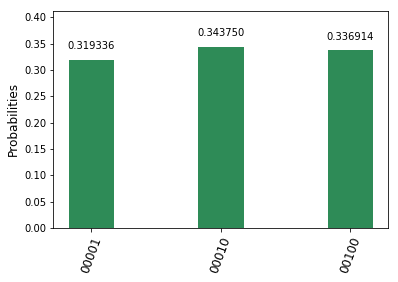

In [19]:
# 3 qubits W state

Q_program = QuantumProgram(specs=QPS_SPECS)
Q_program.set_api(Qconfig.APItoken, Qconfig.config['url'])
W_states = Q_program.get_circuit('W_states') 
q = Q_program.get_quantum_register('q') 
c = Q_program.get_classical_register('c')
        
W_states.x(q[2]) #start is |100>

# Applying F32
theta = np.arccos(np.sqrt(1/3))
W_states.ry(-theta,q[1])
W_states.h(q[1])

if flag_qx2 :
    W_states.barrier(q[1])
    W_states.h(q[1])
    W_states.h(q[2])
    W_states.cx(q[1],q[2])
    W_states.h(q[2])
    W_states.h(q[1])
    W_states.barrier(q[1],q[2])
else:
    W_states.cx(q[2],q[1])

W_states.h(q[1])
W_states.ry(theta,q[1])

# Applying F21
theta = np.arccos(np.sqrt(1/2))
W_states.ry(-theta,q[0])
W_states.h(q[0])

if flag_qx2 :
    W_states.barrier(q[0])
    W_states.h(q[1])
    W_states.h(q[0])
    W_states.cx(q[0],q[1])
    W_states.h(q[0])
    W_states.h(q[1])
    W_states.barrier(q[0])
else :
    W_states.cx(q[1],q[0])

W_states.h(q[0])
W_states.ry(theta,q[0])

# cNOT 12
if flag_qx2 :
    W_states.cx(q[0],q[1])
else :
    W_states.barrier(q[1])
    W_states.h(q[1])
    W_states.h(q[0])
    W_states.cx(q[1],q[0])
    W_states.h(q[1]) 
    W_states.h(q[0])
    W_states.barrier(q[0],q[1])

# cNOT 13
if flag_qx2 :
    W_states.cx(q[0],q[2])
else :
    W_states.h(q[2])
    W_states.h(q[0])
    W_states.cx(q[2],q[0])
    W_states.h(q[0])
    W_states.h(q[2])
    W_states.barrier(q[0],q[2]) 

# cNOT 23
if flag_qx2 :
    W_states.cx(q[1],q[2])
else :
    W_states.h(q[1])
    W_states.h(q[2])
    W_states.cx(q[2],q[1])
    W_states.h(q[1]) 
    W_states.h(q[2])
    W_states.barrier(q[1],q[2])

    
for i in range(3) :
    W_states.measure(q[i] , c[i]) 

circuits = ['W_states']

shots = 1024
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('start W state 3 qubits on', backend, "N=", shots,time_exp)
result = Q_program.execute(circuits, backend=backend, shots=shots, max_credits=5, wait=5, timeout=1200)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('end   W state 3 qubits on', backend, "N=", shots,time_exp)
plot_histogram(result.get_counts('W_states'))

Now you get an histogram compatible with the state:

$$ |W_{3}\rangle \;=\; \frac{1}{\sqrt{3}} \: (\:|001\rangle \: +  |010\rangle \: + |100\rangle \:) $$

Bingo!

## Four qubit W state

In this section, the production of a four qubit W state will be obtained by extending the previous circuit.

In the programmation, the starting state is now: $ |\varphi \rangle \, = \, |1000\rangle$.

The $F_{4,3}$ gate was added at the beginning of the program and three additionnal cNOT gates were added before the measurement phase.

Since there are missing connections between certain qubits on the actual apparatus, a swap was necessary.

Run the following cell and see what happens.

start W state 4 qubits on local_qasm_simulator N= 1024 18/02/2018 17:44:38
end   W state 4 qubits on local_qasm_simulator N= 1024 18/02/2018 17:44:45


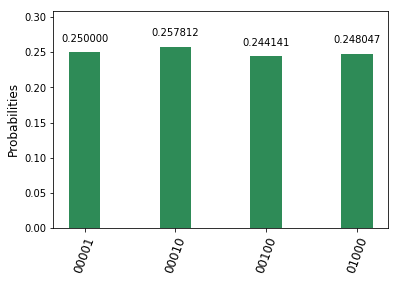

In [20]:
# 4 qubits W state

Q_program = QuantumProgram(specs=QPS_SPECS)
Q_program.set_api(Qconfig.APItoken, Qconfig.config['url'])
W_states = Q_program.get_circuit('W_states') 
q = Q_program.get_quantum_register('q') 
c = Q_program.get_classical_register('c')
        
W_states.x(q[3]) #start is |1000>

# Applying F43
theta = np.arccos(np.sqrt(1/4)) 
W_states.ry(-theta,q[2])
W_states.h(q[2])
W_states.cx(q[3],q[2])
W_states.h(q[2])
W_states.ry(theta,q[2])

# Applying F32
theta = np.arccos(np.sqrt(1/3))
W_states.ry(-theta,q[1])
W_states.h(q[1])

if flag_qx2 :
    W_states.barrier(q[1])
    W_states.h(q[1])
    W_states.h(q[2])
    W_states.cx(q[1],q[2])
    W_states.h(q[2])
    W_states.h(q[1])
    W_states.barrier(q[1],q[2])
else:
    W_states.cx(q[2],q[1])

W_states.h(q[1])
W_states.ry(theta,q[1])

# Applying F21
theta = np.arccos(np.sqrt(1/2))
W_states.ry(-theta,q[0])
W_states.h(q[0])

if flag_qx2 :
    W_states.barrier(q[0])
    W_states.h(q[1])
    W_states.h(q[0])
    W_states.cx(q[0],q[1])
    W_states.h(q[0])
    W_states.h(q[1])
    W_states.barrier(q[0])
else :
    W_states.cx(q[1],q[0])

W_states.h(q[0])
W_states.ry(theta,q[0])

# cNOT 12
if flag_qx2 :
    W_states.cx(q[0],q[1])
else :
    W_states.barrier(q[1])
    W_states.h(q[1])
    W_states.h(q[0])
    W_states.cx(q[1],q[0])
    W_states.h(q[1]) 
    W_states.h(q[0])
    W_states.barrier(q[0],q[1])

# cNOT 13
if flag_qx2 :
    W_states.cx(q[0],q[2])
else :
    W_states.h(q[2])
    W_states.h(q[0])
    W_states.cx(q[2],q[0])
    W_states.h(q[0])
    W_states.h(q[2])
    W_states.barrier(q[0],q[2]) 

# cNOT 23
if flag_qx2 :
    W_states.cx(q[1],q[2])
else :
    W_states.h(q[1])
    W_states.h(q[2])
    W_states.cx(q[2],q[1])
    W_states.h(q[1]) 
    W_states.h(q[2])
    W_states.barrier(q[1])

#Swap q[3],q[2]
W_states.cx(q[3],q[2])
W_states.h(q[2])
W_states.h(q[3])
W_states.cx(q[3],q[2])
W_states.h(q[3])
W_states.h(q[2])
W_states.cx(q[3],q[2])
    
# cNOT 14
if flag_qx2 :
    W_states.cx(q[0],q[2])
else :
    W_states.h(q[2])
    W_states.h(q[0])
    W_states.cx(q[2],q[0])
    W_states.h(q[0])
    W_states.h(q[2])
    W_states.barrier(q[0],q[2]) 

# cNOT 24
if flag_qx2 :
    W_states.cx(q[1],q[2])
else :
    W_states.h(q[1])
    W_states.h(q[2])
    W_states.cx(q[2],q[1])
    W_states.h(q[1]) 
    W_states.h(q[2])
    W_states.barrier(q[1])

# cNOT 34
W_states.cx(q[3],q[2])
    
for i in range(4) :
    W_states.measure(q[i] , c[i]) 

circuits = ['W_states']

shots = 1024
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('start W state 4 qubits on', backend, "N=", shots,time_exp)
result = Q_program.execute(circuits, backend=backend, shots=shots, max_credits=5, wait=5, timeout=1200)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('end   W state 4 qubits on', backend, "N=", shots,time_exp)
plot_histogram(result.get_counts('W_states'))

Now you get an histogram compatible with the state:

$$ |W_{4}\rangle \;=\; \sqrt{\frac{1}{4}} \: (\:|0001\rangle \: +  |0010\rangle \: + |0100\rangle \: + |1000\rangle \:) $$

Wow!

## Five qubit W state

In this section, a five qubit W state will be obtained, again by extending the previous circuit.

In the programmation, the starting state is now: $ |\varphi \rangle \, = \, |10000\rangle$.

The $F_{5,4}$ gate was added at the beginning of the program and four additionnal cNOT gates were added before the measurement phase.

Since there are missing connections between certain qubits on the actual apparatus, a second swap was necessary.

Run the following cell and see what happens.

start W state 5 qubits on local_qasm_simulator N= 1024 18/02/2018 17:44:53
end   W state 5 qubits on local_qasm_simulator N= 1024 18/02/2018 17:45:02


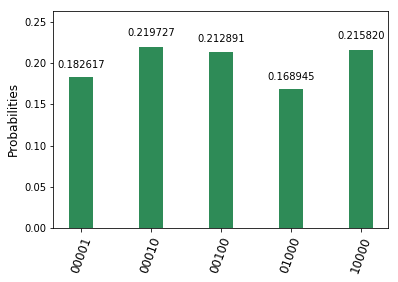

In [21]:
# 5 qubits W state

Q_program = QuantumProgram(specs=QPS_SPECS)
Q_program.set_api(Qconfig.APItoken, Qconfig.config['url'])
W_states = Q_program.get_circuit('W_states') 
q = Q_program.get_quantum_register('q') 
c = Q_program.get_classical_register('c')
        
W_states.x(q[4]) #start is |10000>

# Applying F54
theta = np.arccos(np.sqrt(1/5))
W_states.ry(-theta,q[3])
W_states.h(q[3])

W_states.barrier(q[3])
W_states.h(q[3])
W_states.h(q[4])
W_states.cx(q[3],q[4])
W_states.h(q[4])
W_states.h(q[3])
W_states.barrier(q[3])

W_states.h(q[3])
W_states.ry(theta,q[3])

# Applying F43
theta = np.arccos(np.sqrt(1/4)) 
W_states.ry(-theta,q[2])
W_states.h(q[2])
W_states.cx(q[3],q[2])
W_states.h(q[2])
W_states.ry(theta,q[2])

# Applying F32
theta = np.arccos(np.sqrt(1/3))
W_states.ry(-theta,q[1])
W_states.h(q[1])

if flag_qx2 :
    W_states.barrier(q[1])
    W_states.h(q[1])
    W_states.h(q[2])
    W_states.cx(q[1],q[2])
    W_states.h(q[2])
    W_states.h(q[1])
    W_states.barrier(q[1],q[2])
else:
    W_states.cx(q[2],q[1])

W_states.h(q[1])
W_states.ry(theta,q[1])

# Applying F21
theta = np.arccos(np.sqrt(1/2))
W_states.ry(-theta,q[0])
W_states.h(q[0])

if flag_qx2 :
    W_states.barrier(q[0])
    W_states.h(q[1])
    W_states.h(q[0])
    W_states.cx(q[0],q[1])
    W_states.h(q[0])
    W_states.h(q[1])
    W_states.barrier(q[0])
else :
    W_states.cx(q[1],q[0])

W_states.h(q[0])
W_states.ry(theta,q[0])

# cNOT 12
if flag_qx2 :
    W_states.cx(q[0],q[1])
else :
    W_states.barrier(q[1])
    W_states.h(q[1])
    W_states.h(q[0])
    W_states.cx(q[1],q[0])
    W_states.h(q[1]) 
    W_states.h(q[0])
    W_states.barrier(q[0],q[1])

# cNOT 13
if flag_qx2 :
    W_states.cx(q[0],q[2])
else :
    W_states.h(q[2])
    W_states.h(q[0])
    W_states.cx(q[2],q[0])
    W_states.h(q[0])
    W_states.h(q[2])
    W_states.barrier(q[0],q[2]) 

# cNOT 23
if flag_qx2 :
    W_states.cx(q[1],q[2])
else :
    W_states.h(q[1])
    W_states.h(q[2])
    W_states.cx(q[2],q[1])
    W_states.h(q[1]) 
    W_states.h(q[2])
    W_states.barrier(q[1])

#Swap q[3],q[2]
W_states.cx(q[3],q[2])
W_states.h(q[2])
W_states.h(q[3])
W_states.cx(q[3],q[2])
W_states.h(q[3])
W_states.h(q[2])
W_states.cx(q[3],q[2])
    
# cNOT 14
if flag_qx2 :
    W_states.cx(q[0],q[2])
else :
    W_states.h(q[2])
    W_states.h(q[0])
    W_states.cx(q[2],q[0])
    W_states.h(q[0])
    W_states.h(q[2])
    W_states.barrier(q[0],q[2]) 

# cNOT 24
if flag_qx2 :
    W_states.cx(q[1],q[2])
else :
    W_states.h(q[1])
    W_states.h(q[2])
    W_states.cx(q[2],q[1])
    W_states.h(q[1]) 
    W_states.h(q[2])
    W_states.barrier(q[1])

# cNOT 34
W_states.cx(q[3],q[2])

# cNOT 45
if flag_qx2 :
    W_states.barrier(q[4])
    W_states.h(q[4])
    W_states.h(q[2])
    W_states.cx(q[4],q[2])
    W_states.h(q[2])
    W_states.h(q[4])
    W_states.barrier(q[4])
else:
    W_states.cx(q[2],q[4])

# cNOT 35
W_states.cx(q[3],q[4])

# Swap q[2],q[4]
if flag_qx2 :
    W_states.cx(q[4],q[2])
    W_states.h(q[2])
    W_states.h(q[4])
    W_states.cx(q[4],q[2])
    W_states.h(q[4])
    W_states.h(q[2])
    W_states.cx(q[4],q[2])
else :
    W_states.cx(q[2],q[4])
    W_states.h(q[2])
    W_states.h(q[4])
    W_states.cx(q[2],q[4])
    W_states.h(q[4])
    W_states.h(q[2])
    W_states.cx(q[2],q[4])

# cNOT 15
if flag_qx2 :
    W_states.cx(q[0],q[2])
else :
    W_states.h(q[2])
    W_states.h(q[0])
    W_states.cx(q[2],q[0])
    W_states.h(q[0])
    W_states.h(q[2])
    W_states.barrier(q[0],q[2]) 

# cNOT 25
if flag_qx2 :
    W_states.cx(q[1],q[2])
else :
    W_states.h(q[1])
    W_states.h(q[2])
    W_states.cx(q[2],q[1])
    W_states.h(q[1]) 
    W_states.h(q[2])
    W_states.barrier(q[1],q[2]) 

for i in range(5) :
    W_states.measure(q[i] , c[i]) 

circuits = ['W_states']

shots = 1024
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('start W state 5 qubits on', backend, "N=", shots,time_exp)
result = Q_program.execute(circuits, backend=backend, shots=shots, max_credits=5, wait=5, timeout=1200)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('end   W state 5 qubits on', backend, "N=", shots,time_exp)
plot_histogram(result.get_counts('W_states'))

Now, if you used the simulator, you see an histogram compatible with the state:

$$|W_{5}\rangle=\frac{1}{\sqrt{5}}\:(\:|00001\rangle\:+|00010\rangle\:+|00100\rangle\:+|01000\rangle\:+|10000\rangle\:)$$

But if you were running the program on one of the available real quantum computers, things are less clear: the errors are spreading.

## Conclusion:

When the local simulator is used, the results accurately reflect the expected spectrum of frequency for the set of observables corresponding to a given n value.

For n < 5 on real quantum computers, the results are obviously in accordance with the creation of W states.

The errors amplify significantly for n = 5, but the histogram shows the persistence of several frequency peaks compatible with a W state.

One obvious cause of error is the increasing number of gates. Even for an ideal quantum computer, where all the qubits are connected together bidirectionally, the number of cNOT gates, y-rotation gates and H gates necessary for building the $F$ gates increases linearly while the number of cNOT gates used afterwards increases in a quadratic way, following the triangular numbers sequence. Another cause of error is the interval between successive values of $\theta \, (k)$ which decreases significantly as n increases.


In [22]:
%run "../version.ipynb"

Package,Version
QISKit,0.4.8
IBMQuantumExperience,>= 1.8.26
numpy,">= 1.13, < 1.14"
scipy,">= 0.19, < 0.20"
matplotlib,">= 2.0, < 2.1"
